In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import warnings
from sklearn.metrics import jaccard_score

# Suppress FutureWarnings temporarily
warnings.simplefilter("ignore", category=FutureWarning)

In [2]:
# !pip install gensim
import time
from tqdm.notebook import tqdm
import gensim
from gensim.models import FastText 
import nltk; #nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import *
from sklearn.metrics import ConfusionMatrixDisplay


In [3]:
# Models
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.svm import LinearSVC
from sklearn.linear_model import RidgeClassifier
from time import time
import re
import warnings

In [4]:
trainDF = pd.read_csv('data/data_raw/train_essays.csv')
testDF = pd.read_csv('data/data_raw/test_essays.csv')
promptsDF = pd.read_csv('data/data_raw/train_prompts.csv')

In [5]:
trainDF.head()

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


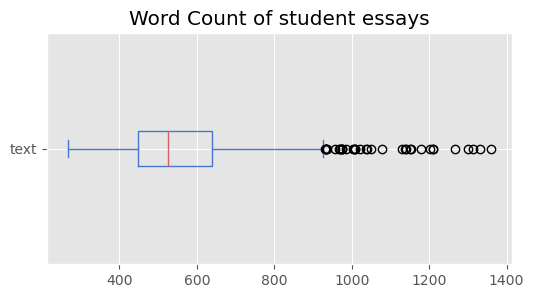

In [132]:
plt.style.use('seaborn-v0_8-muted')
trainDF[trainDF.generated==0].text.str.split().apply(len).plot.box(figsize=(6,3), vert=False);
plt.title("Word Count of student essays");

# Prompt LLMs for essays

- Act as a high school student. Write an explanatory essay to inform fellow citizens about the advantages of limiting car usage. Here are sources for inspiration:
- Act as a high school student. Write an explanatory essay to inform fellow citizens about the advantages of limiting car usage. Here is an example:
- Act as a high school student. Write an explanatory essay to inform fellow citizens about the advantages of limiting car usage. Don't output titles or headers, dont use " ".  Limit your responce to 300-800 words. 
- Act as a high school student.Discuss why it's a good idea to stick with the Electoral College or switch to a popular vote when choosing the U.S. President.Dont use titles.  dont use Sincerely, [Your Name][Your Address][City, State, ZIP Code][Email Address][Phone Number].
- Write 300 words to your state senator in which you argue in favor of keeping the Electoral College or changing to election by popular vote for the president of the United States. Dont use titles.  dont use Sincerely, [Your Name][Your Address][City, State, ZIP Code][Email Address][Phone Number].
- Write a letter to your state senator in which you argue in favor of keeping the Electoral College or changing to election by popular vote for the president of the United States. Use the information from the texts in your essay. Manage your time carefully so that you can read the passages; plan your response; write your response; and revise and edit your response. Be sure to include a claim; address counterclaims; use evidence from multiple sources; and avoid overly relying on one source. Your response should be in the form of a multiparagraph essay. Dont use titles.Here are the texts:
- act as a high school student. write a significantly different letter than your last
- write a short essay to explain your opinions on the matter. act as a student
- act as a 6th grade student. write an essay using the intructions from your first prompt
- adopt a random personality write a short essay on the matter
- you are a little boy. write 3 paragraphs on the matter
- act as a 12th grade student writing in your school's paper. Write an essay to convince your schoolmates that cities would be better off with fewer cars. Dont use titles
- Your fellow classmates were not convinced. Write 3 paragraphs using different reasons
- you are a 6th grader. your teacher wants you to write an essay as to why cities would be better with fewer cars. include no titles
- think of different reasons
- Write an explanatory essay to inform fellow citizens about the advantages of limiting car usage. Your essay must be based on ideas and information that can be found in the passage set. Manage your time carefully so that you can read the passages; plan your response; write your response; and revise and edit your response. Be sure to use evidence from multiple sources; and avoid overly relying on one source. Your response should be in the form of a multiparagraph essay. Dont print titles and paragraph titles. Here are the passage set:
- act as a high school student. use the first prompt to write a different essay.

## Use student essays as examples for the prompts:

In [15]:
promptsDF.head()

,prompt_id,prompt_name,instructions,source_text
0,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ..."
1,1,Does the electoral college work?,Write a letter to your state senator in which ...,# What Is the Electoral College? by the Office...


Keep the instructions to feed as prompts to the LLM

In [16]:
# Strip the full prompt
car_prompt_full = '.'.join(promptsDF[promptsDF.prompt_id==0].instructions.values[0].split('.')[:-2])
college_prompt_full = '.'.join(promptsDF[promptsDF.prompt_id==1].instructions.values[0].split('.')[:-2])
# print( car_prompt_full  )
# print( college_prompt_full )

In [17]:
# Strip the minimal prompt
car_prompt_mini = car_prompt_full.split('.')[0]
college_prompt_mini = college_prompt_full.split('.')[0]
print(car_prompt_mini )
print(college_prompt_mini )

Write an explanatory essay to inform fellow citizens about the advantages of limiting car usage
Write a letter to your state senator in which you argue in favor of keeping the Electoral College or changing to election by popular vote for the president of the United States


## Strip the sources.

In [18]:
car_sources = promptsDF[promptsDF.prompt_id==0].source_text.values[0]
college_sources = promptsDF[promptsDF.prompt_id==1].source_text.values[0]
#car_sources

In [19]:
#car_sources.split('#')[1:] # Giati to 1o element einai keno

## Print one source for training

In [20]:
# split the sources of each prompt for more variation
import random,pprint
# x=random.sample(car_sources.split('#'),2)
x=random.choice(car_sources.split('#'))
# print(x)

# Plot the data

In [21]:
trainDF.head()

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


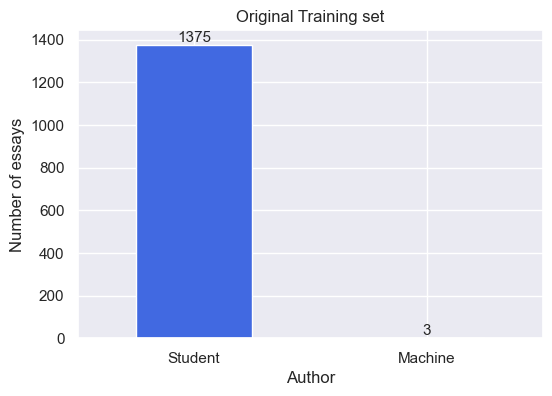

In [23]:
plt.style.use('seaborn-v0_8-muted')
ax = trainDF.generated.value_counts().plot.bar(rot=0, color=['royalblue','tomato'], figsize=(6,4))
ax.set_xticklabels(['Student','Machine'])
ax.set_title('Original Training set')
ax.set_xlabel('Author')
ax.set_ylabel('Number of essays');
# Adding annotations
for i, count in enumerate(trainDF.generated.value_counts()):
    ax.text(i, count + 0.1, str(count), ha='center', va='bottom', fontsize=11)

# Show the plot
plt.savefig('original_data.svg')
plt.show()

# Import the augmentation set

## Create the training set

In [65]:
# Load my AI text
# model 0 = gpt3.5, model 1 = bard
myLLM = pd.read_csv('augmentation.csv')
myLLM['label'] = 1
myLLM

,model,prompt,text,label
0,0,0,"In recent years, our society has been grapplin...",1
1,0,0,"For most people, hopping in a car is the norm ...",1
2,0,0,"In recent years, the issue of limiting car usa...",1
3,0,0,As high school students navigating our way thr...,1
4,0,0,"Hey, fellow students! Let's dive into a topic ...",1
...,...,...,...,...
60,1,0,"Hey everyone, let's stop relying on cars so m...",1
61,1,0,"As responsible citizens, it is imperative that...",1
62,1,0,As an engaged and environmentally conscious co...,1
63,1,0,"As a responsible community, we must collective...",1


In [ ]:
# supplementary augmentation set
# https://www.kaggle.com/datasets/thedrcat/daigt-proper-train-dataset/

In [66]:
# Load the augmented training set (competition data + LLM generated)
trainSet = pd.read_csv('data/data_raw/DAIGT Proper Train Dataset/train_drcat_04.csv')
trainSet.sample(5)

,essay_id,text,label,source,prompt,fold
4527,86ECF13FEDEF,First impressions can have an immense effect o...,1,chat_gpt_moth,Task: Research how first impressions can effec...,1
3162,B7FCFC6A7011,"Sure, here's my essay response:\n\nAs an 8th g...",1,llama2_chat,Task:\n1. Research pet daycares to learn more ...,9
34613,E9947D032E7B,"Hey, I'm just a regular 8th grader, so bear wi...",1,llama2_chat,Task: Write an essay that discusses the greate...,7
38382,65EE45F7743C,"Phones & Driving\n\nTo begin with, today I am ...",0,persuade_corpus,NaN,4
38734,AC9801E7B7A1,Most students enjoy participating in extracurr...,0,persuade_corpus,NaN,9


In [67]:
sum(trainDF.text.isin(trainSet.text)) # proof that all original essays are in the training set

1378

In [68]:
# Make my training set of 6K essays
trainSet = pd.concat([
    myLLM[['text','label']], # My AI text
    trainSet[trainSet.source=='train_essays'][['text','label']], # The original student + LLM texts
    trainSet[trainSet.source=='persuade_corpus'].sample(1625, random_state=42)[['text','label']], # The augmented student texts
    trainSet[trainSet.label==1].sample(2933, random_state=42)[['text','label']] # The 3rd party LLM texts
])

In [69]:
print(trainSet.groupby('label').describe())
trainSet.drop_duplicates(inplace=True)
print(trainSet.groupby('label').describe())

# Map values in 'binary_column' to 'student' and 'machine'
trainSet['author'] = trainSet['label'].map({0: 'Student', 1: 'Machine'})
trainSet.sample(5)

       text                                                               
      count unique                                                top freq
label                                                                     
0      3000   3000  The electoral college is a symbol of mockery a...    1
1      3001   3000  I strongly believe that the Electoral College ...    2
       text                                                               
      count unique                                                top freq
label                                                                     
0      3000   3000  The electoral college is a symbol of mockery a...    1
1      3000   3000  In recent years, our society has been grapplin...    1


,text,label,author
44124,Exploring Venus\n\nI wounder why Venus called ...,0,Student
42391,"Since Henry Ford made the first Model T, peopl...",0,Student
24965,Cars may actually disappear from the modern wo...,0,Student
34457,The idea of extending school days to four day...,1,Machine
41279,Title: Exploring the Cultural and Historical W...,1,Machine


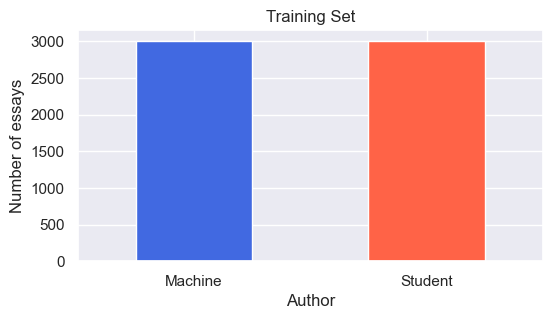

In [70]:
ax = trainSet.author.value_counts().plot.bar(rot=0, color=['royalblue','tomato'], figsize=(6,3));
# ax.set_xticklabels(['Student','Machine'])
ax.set_title('Training Set')
ax.set_xlabel('Author')
ax.set_ylabel('Number of essays');


## Keep a portion of the augmentation set as validation set.

In [85]:
validationSet = pd.read_csv('data/data_raw/DAIGT Proper Train Dataset/train_drcat_01.csv')
validationSet['author'] = validationSet['label'].map({0: 'Student', 1: 'Machine'})
validationSet.sample(5)

,text,label,source,fold,author
9778,"Summer projects, one of the most boring things...",0,persuade_corpus,0,Student
24411,This would be good for students in many ways. ...,0,persuade_corpus,4,Student
29565,"As an 8th-grade student, it is important to st...",1,llammistral7binstruct,1,Machine
5740,Ring!\n\nThe bell signals the end of school. Y...,0,persuade_corpus,1,Student
15118,Home school is a benefit that anybody could ha...,0,persuade_corpus,4,Student


In [86]:
sum(trainDF.text.isin(validationSet.text)) # proof that the persuade_corpus is different from the students text of the competition.

0

In [87]:
validationSet.groupby(['label','source']).count()

text   fold  author
label source                                     
0     persuade_corpus        25996  25996   25996
1     chat_gpt_moth           2421   2421    2421
      llama2_chat             2421   2421    2421
      llammistral7binstruct   2421   2421    2421

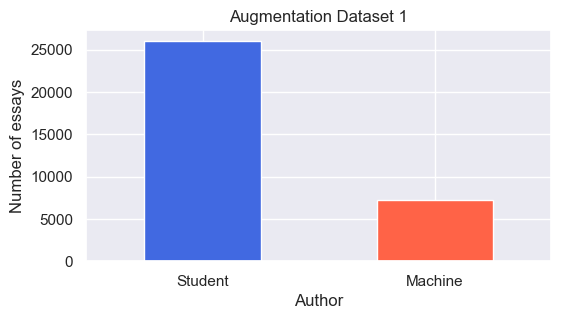

In [88]:
ax = validationSet.author.value_counts().plot.bar(rot=0, color=['royalblue','tomato'], figsize=(6,3))
# ax.set_xticklabels(['Student','Machine'])
ax.set_title('Augmentation Dataset 1')
ax.set_xlabel('Author')
ax.set_ylabel('Number of essays');

In [89]:
validationSet = pd.concat([
    validationSet[validationSet.label==0].sample(5000, random_state=42),
    validationSet[validationSet.label!=0].sample(5000, random_state=42)
])
validationSet.drop(columns=['source','fold'], inplace = True)

validationSet.sample(5)

,text,label,author
7865,The debate between lengthening the school day ...,1,Machine
2981,Some say students should get projects over the...,0,Student
29955,"As an eighth-grade student, I believe that ext...",1,Machine
309,"As an 8th grader, I have been thinking a lot a...",1,Machine
11049,that society's expectations and norms can limi...,1,Machine


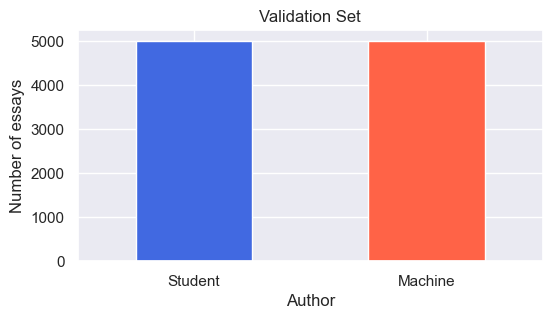

In [91]:
ax = validationSet.author.value_counts().plot.bar(rot=0, color=['royalblue','tomato'], figsize=(6,3))
# ax.set_xticklabels(['Student','Machine'])
ax.set_title('Validation Set')
ax.set_xlabel('Author')
ax.set_ylabel('Number of essays');

### A2] Build text classifiers on the augmented data, using cross-validation with appropriate classification evaluation metrics to assess them, and suggest the best performing one.

In [93]:
# def embed(text, model):
#     words = word_tokenize(text)
#     embeddings = [model.wv[w] for w in words]
#     centroid = np.mean(embeddings, axis=0)
#     return centroid

In [94]:
def benchmark(model, vectorizer, model_name=None) :
    results, predictions, gold = [], [], []
    t0 = time()
    for i in tqdm(range(5)): # 5-fold Cross Validation
        X_train, X_test, y_train, y_test = train_test_split(
            trainSet.text, trainSet.label, test_size=0.3, stratify=trainSet.label)
        clf = model
        X_train = vectorizer.fit_transform(X_train)
        clf.fit(X_train,y_train)
        predictions = clf.predict(vectorizer.transform(X_test))
        # gold.append(y_test) 
        results.append( f1_score(y_test,
                                predictions,
                                zero_division=0,
                                average='macro')) 
        
    results_pd = pd.DataFrame(results)
    test_time = time() - t0
    print(f'Macro F1: {results_pd[0].mean():.2f} ± {results_pd[0].sem():.2f} time: {test_time:.2f}')
    return results_pd[0].mean(), model_name, test_time, clf


In [95]:
vectorizer = TfidfVectorizer()

# Assess classifiers
# Inspired by: https://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.html#sphx-glr-auto-examples-text-plot-document-classification-20newsgroups-py
results = []
for clf, name in (
    (LogisticRegression(max_iter=1000), "Logistic Regression"),
    (RidgeClassifier(alpha=1.0, solver="sparse_cg"), "Ridge Classifier"),
    # (KNeighborsClassifier(n_neighbors=100), "kNN"), # Too slow too bad
    #(RandomForestClassifier(), "Random Forest"), # Too slow too bad
    # L2 penalty Linear SVC
    (LinearSVC(C=0.1, dual=False, max_iter=1000), "Linear SVC"),
    # L2 penalty Linear SGD
    (
        SGDClassifier(
            loss="log_loss", alpha=1e-4, n_iter_no_change=3, early_stopping=True
        ),
        "log-loss SGD",
    ),
    # NearestCentroid (aka Rocchio classifier)
    (NearestCentroid(), "NearestCentroid"),
    # Sparse naive Bayes classifier
    (ComplementNB(alpha=0.1), "Complement naive Bayes"),
):
    print("=" * 80)
    print(name)
    results.append(benchmark(clf, vectorizer, model_name = name))

Logistic Regression


  0%|          | 0/5 [00:00<?, ?it/s]

Macro F1: 0.98 ± 0.00 time: 11.68
Ridge Classifier


  0%|          | 0/5 [00:00<?, ?it/s]

Macro F1: 0.99 ± 0.00 time: 10.60
Linear SVC


  0%|          | 0/5 [00:00<?, ?it/s]

Macro F1: 0.98 ± 0.00 time: 10.64
log-loss SGD


  0%|          | 0/5 [00:00<?, ?it/s]

Macro F1: 0.98 ± 0.00 time: 10.28
NearestCentroid


  0%|          | 0/5 [00:00<?, ?it/s]

Macro F1: 0.85 ± 0.00 time: 10.12
Complement naive Bayes


  0%|          | 0/5 [00:00<?, ?it/s]

Macro F1: 0.94 ± 0.00 time: 10.02


#### Results
We choose the best classifier to be **Logistic Regression** because it is fast, efficient and has the ability to predict the probability that a given text is generated.
#### Validation
We now train a Logistic Regression Classifier on the entirety of the training set and then we will test it on the validation set.

In [96]:
vectorizer = TfidfVectorizer()
X, y = vectorizer.fit_transform(trainSet.text), trainSet.label
logistic = LogisticRegression(max_iter=1000).fit(X,y)
y_pred = logistic.predict(vectorizer.transform(validationSet.text))
print( classification_report(validationSet.label,
                             y_pred,
                             zero_division=0))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      5000
           1       0.98      1.00      0.99      5000

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



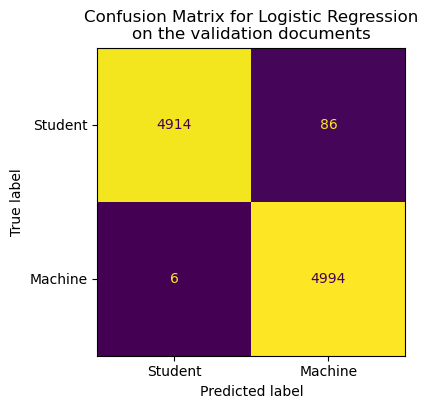

In [98]:
plt.style.use('default')
fig, ax = plt.subplots(figsize=(4,4))
ConfusionMatrixDisplay.from_predictions(validationSet.label,
                                             y_pred,
                                             colorbar=False,
                                             ax=ax)
ax.xaxis.set_ticklabels(['Student','Machine'])
ax.yaxis.set_ticklabels(['Student','Machine'])
_ = ax.set_title(
    f"Confusion Matrix for Logistic Regression\non the validation documents"
)

This model has a high Type1 error. Because it is worse to invalidate the hard work of a student by unjustly classifying it as ‘Generated’, we choose to balance the type1 and type2 errors by inflating the weight of the class 0.

In [99]:
vectorizer = TfidfVectorizer()
X, y = vectorizer.fit_transform(trainSet.text), trainSet.label
logistic = LogisticRegression(max_iter=1000,class_weight={0: 3}).fit(X,y)
y_pred = logistic.predict(vectorizer.transform(validationSet.text))
print( classification_report(validationSet.label,
                             y_pred,
                             zero_division=0))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      5000
           1       1.00      0.99      1.00      5000

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



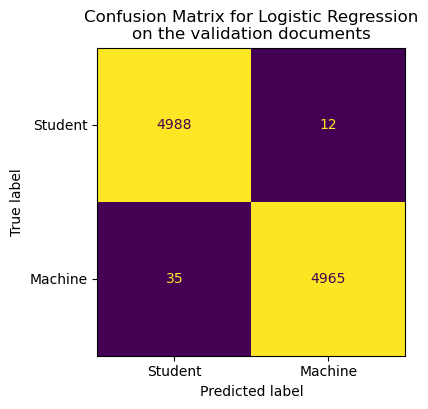

In [100]:
fig, ax = plt.subplots(figsize=(4,4))
ConfusionMatrixDisplay.from_predictions(validationSet.label,
                                             y_pred,
                                             colorbar=False,
                                             ax=ax)
ax.xaxis.set_ticklabels(['Student','Machine'])
ax.yaxis.set_ticklabels(['Student','Machine'])
_ = ax.set_title(
    f"Confusion Matrix for Logistic Regression\non the validation documents"
)

### A3]
Compute two scores per generated text, one reflecting the maximum and the other the average
similarity of that text with student essays.

In [101]:
essaysGen = trainSet[trainSet.label==1]
essaysSdn = trainSet[trainSet.label==0]

essaysGen['text'] = essaysGen.text.apply(word_tokenize)
essaysSdn['text'] = essaysSdn.text.apply(word_tokenize)

C:\Users\Foivos\AppData\Local\Temp\ipykernel_8964\2261145566.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  essaysGen['text'] = essaysGen.text.apply(word_tokenize)
C:\Users\Foivos\AppData\Local\Temp\ipykernel_8964\2261145566.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  essaysSdn['text'] = essaysSdn.text.apply(word_tokenize)


In [102]:
similarities = np.zeros((essaysGen.shape[0],3))

In [179]:
# x = set( essaysGen.iloc[0,0] )
# y = set( essaysSdn.iloc[0,0] )
# jaccard(x,y)

0.10625

In [103]:
jaccard = lambda x,y: len(x.intersection(y))/len(x.union(y))
for i, generated in enumerate( essaysGen.text ): 
    similarity = []
    for original in essaysSdn.text:
        similarity.append(jaccard(set( generated ),set( original )) )

    similarities[i,1] = np.mean(similarity)
    similarities[i,2] = np.max(similarity)

In [114]:
similarities[:,0] = essaysGen.index


In [115]:
similaritiesDF = pd.DataFrame({'mean':similarities[:,1], 'max':similarities[:,2]}, index=similarities[:,0].astype(int) )
similaritiesDF = similaritiesDF.round(2)
similaritiesDF.head()

,mean,max
0,0.12,0.19
1,0.12,0.27
2,0.11,0.20
3,0.11,0.19
4,0.15,0.23


### A4]
- Study the correlation between the similarity scores and the prediction probability of your best
classifier for the generated texts;
- compute the prediction probability per text, by training the selected
classifier on all except from that text, which is used as a test instance (a.k.a. the leave-one-out cross-
validation setting).

In [241]:
from sklearn.model_selection import LeaveOneOut

# Shuffle the DataFrame
shuffled = trainSet.sample(frac=1, random_state=42)
y = shuffled['label']
X = shuffled['text']
idx = shuffled.index

model = LogisticRegression(max_iter=1000,class_weight={0: 3})
loo = LeaveOneOut()

shuffled.head()

,text,label
40186,"According to the article ""Making Mona Lisa Smi...",0
14775,Self-esteem is a crucial aspect of a person's ...,1
5567,The electoral college has been a part of the u...,0
13355,"As a teen growing up in the digital age, I use...",0
30988,I believe that dress codes are beneficial for ...,1


In [ ]:
# DO NOT RE-RUN !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# == Leave One Out ==
# probas = []
# for train_index, test_index in loo.split(X):
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]

#     X_train = vectorizer.fit_transform(X_train)
#     model.fit(X_train, y_train)
#     y_pred = model.predict_proba(vectorizer.transform(X_test))
#     probas.append(y_pred)

# print(probas)


In [236]:
matrix_result = np.vstack(probas)
probasDF = pd.DataFrame({'GenProba': matrix_result[:,1]}, index=idx)
probasDF =  probasDF.round(2)
probasDF.to_csv('leaveOneOut1.csv')
probasDF.head()

,GenProba
38162,0.26
15061,0.98
31436,0.07
12804,0.00
38823,0.00


In [123]:
probasDF = pd.read_csv('leaveOneOut.csv', index_col=0)

In [124]:
probasDF.head()

,GenProba
38162,0.26
15061,0.98
31436,0.07
12804,0.00
38823,0.00


In [125]:
trainSet.sample(5)

,text,label,author
18554,Dont get me wrong cars are a good thing for bu...,0,Student
27175,Many people believe that the face on Mars was ...,0,Student
25127,"Dear State Senator, Every four years, the time...",0,Student
28598,Gun control is a really important issue that a...,1,Machine
26522,"Hey there! So, I've been thinking a lot about...",1,Machine


In [ ]:
# trainSet['GenProba'] = probasDF.sort_index().iloc[:,1].values
# trainSet.head(10)
newTrainDF = pd.concat([ trainSet.sort_index(),
                        probasDF.sort_index().GenProba
                        ], axis=1, ignore_index=True)

newTrainDF.rename( columns={ 0:'text', 1:'label', 2:'genProb'}, inplace=True)
newTrainDF.head(10)
# probasDF.sort_index().GenProba

In [252]:
# Find unique elements and their counts
unique_elements, counts = np.unique(idx, return_counts=True)
# Find elements that are not unique (have counts greater than 1)
not_unique_elements = unique_elements[counts > 1]
print("Elements that are not unique:", not_unique_elements)

Elements that are not unique: [ 2  4  7 28 38 40 43 44 63]


- Correlation berween Jaccard similarity and the probability that the text was generated

In [410]:
corDF0 = pd.merge(essaysGen,similaritiesDF, left_index=True, right_index=True).sort_index()
corDF0['genProb'] = newTrainDF[newTrainDF.label==1].genProb
corDF = corDF0.sample(50)
# corDF = corDF.sort_values(by='genProb')
corDF.head(5)

,text,label,mean,max,genProb
30367,"[Sure, ,, here, 's, my, attempt, at, writing, ...",1,0.14,0.23,0.94
3257,"[Dear, Principal, ,, I, hope, this, letter, fi...",1,0.12,0.23,0.95
4,"[I, strongly, believe, that, meditation, and, ...",1,0.09,0.16,0.98
15362,"[I, agree, with, the, principal, 's, decision,...",1,0.13,0.25,0.73
22201,"[Group, work, environments, offer, a, variety,...",1,0.10,0.16,0.99


In [ ]:
plt.style.use('default')

fig, ax = plt.subplots(figsize=(20, 6))  # Adjust the width as needed
plt.plot([], [], color ='tab:blue', 
         label ='Generated prob.')
plt.plot([], [], color ='tab:orange',
         label ='Jaccard Similarity')
plt.stackplot(range(1,corDF.shape[0]+1), corDF['genProb'], corDF['max'])
# Add a horizontal line at y=1
ax.axhline(y=1, color='red', linestyle='--', label='Ideal scenario')

# Customize the plot
# Remove spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_title(' Correlation between the similarity scores and the prediction probability', fontsize= 14)
ax.set_xlabel('Sample of texts')
ax.set_xlim(1,50)
ax.set_ylabel('Probability')
ax.legend(loc='lower right')
caption = "Thesis: The more similar pairs of student-LLM texts are, the harder it should be for the classifier to distinguish the True class. \nFollowing that logic, the correlation between the probability that a text is generated, should be inversely proportional to the maximum similarity of that text to all the rest. \n In the plot above, the ideal scenario is captured at points x=5, x=9, where the probabilities sum to one."
plt.text(0.5, -0.25, caption, fontsize=12, ha='center', transform=ax.transAxes, color='tab:grey')

# Save the plot as a PNG file
plt.savefig('cor Sim VS Prob.png', bbox_inches='tight')

plt.show()

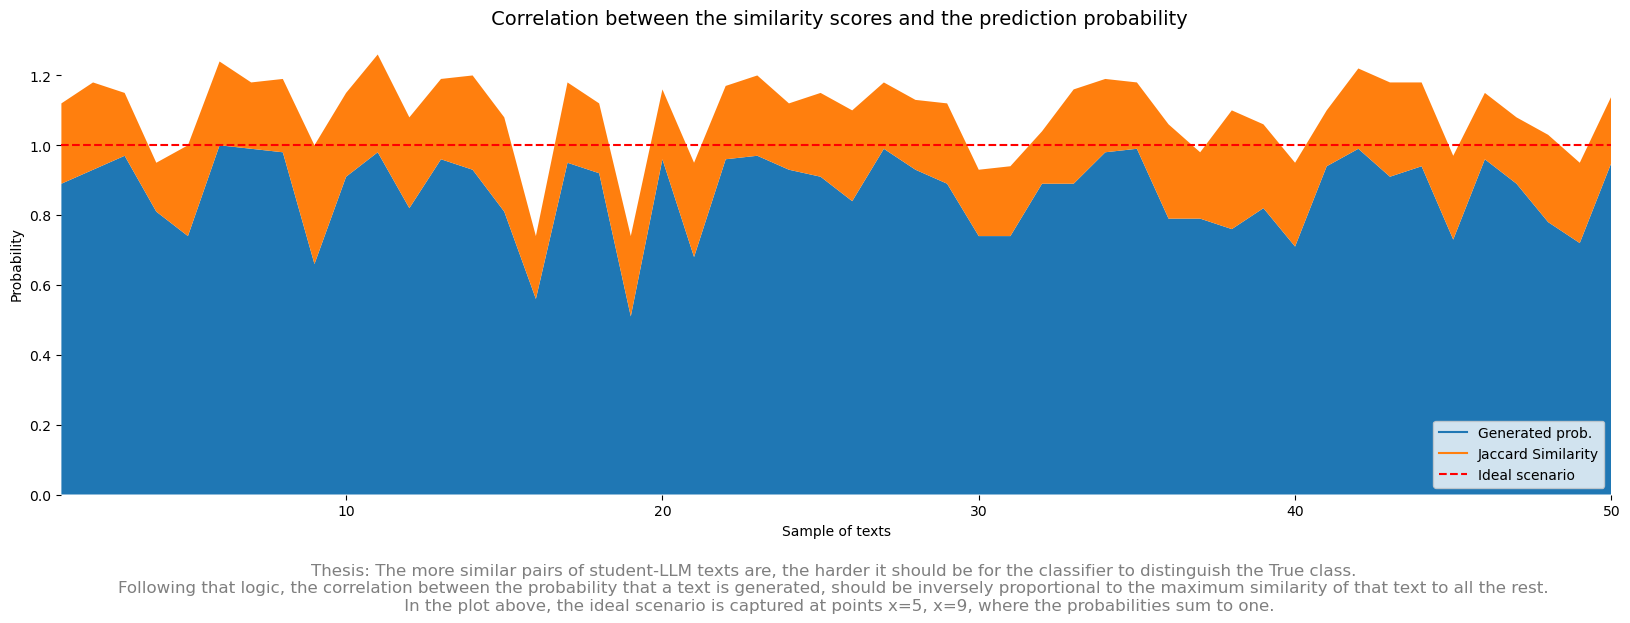

In [127]:
from IPython.display import display, Image
image_path = "img/cor Sim VS Prob.png"  
display(Image(filename=image_path))

### A5]
Based on your study so far, decide which generated texts should be discarded in order to improve
the benchmark and yield a more robust classifier.

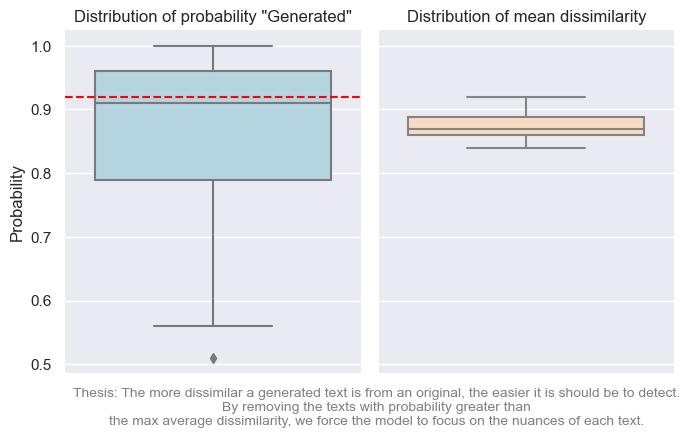

In [403]:
# Use seaborn style
sns.set(style="darkgrid")

# Create a figure with two subplots (one for each column)
fig, axs = plt.subplots(1, 2, figsize=(7,4), sharey=True)

# Box plot for genProb
sns.boxplot(data=corDF, y='genProb', ax=axs[0], color='lightblue')
axs[0].set_title('Distribution of probability "Generated"')
# axs[0].set_yticklabels((axs[0].get_yticks() * 100).round(0))  # Multiply y-axis values by 100
axs[0].set_ylabel('Probability')
axs[0].axhline(y=(1-corDF['mean'].min()), color='red', linestyle='--', label='Vertical Line at y=0.95')  # Add vertical line

# Box plot for max
sns.boxplot(data=corDF, y=(1-corDF['mean']), ax=axs[1], color='peachpuff')
axs[1].set_title('Distribution of mean dissimilarity')
axs[1].set_ylabel('')

# Remove spines
for ax in axs:
    sns.despine(ax=ax, top=True, right=True, left=True, bottom=True)

# Adjust layout to prevent clipping of titles
plt.tight_layout()
caption = "Thesis: The more dissimilar a generated text is from an original, the easier it is should be to detect. \nBy removing the texts with probability greater than \nthe max average dissimilarity, we force the model to focus on the nuances of each text. "
plt.text(0, -0.15, caption, fontsize=10, ha='center', transform=ax.transAxes, color='tab:grey')

# Save the plot as a PNG file
plt.savefig('a5.box1.png', bbox_inches='tight')

# Show the plot
plt.show()

In [513]:
cutoff = 1-corDF0['mean'].min() # max dissimilarity
cutoff1 = corDF0['genProb'].quantile(0.75)
corDF = corDF0[corDF0.genProb < cutoff]
corDF.sample(10)

,text,label,mean,max,genProb
43830,"[The, use, of, Facial, Action, Coding, System,...",1,0.10,0.18,0.92
6669,"[While, distance, learning, offers, flexibilit...",1,0.12,0.24,0.93
33628,"[Hey, there, !, So, ,, like, ,, individuality,...",1,0.14,0.24,0.92
27554,"[Ralph, Waldo, Emerson, 's, quote, ``, To, be,...",1,0.12,0.19,0.89
23776,"[Okay, ,, here, is, my, attempt, at, writing, ...",1,0.16,0.27,0.74
25871,"[Limiting, car, usage, can, provide, significa...",1,0.11,0.28,0.92
23254,"[As, an, 8th, grade, student, ,, I, have, been...",1,0.12,0.21,0.91
40205,"[I, beleive, that, schools, should, implement,...",1,0.13,0.23,0.72
24729,"[Planning, and, organization, are, crucial, wh...",1,0.13,0.22,0.57
31257,"[Year-round, schools, have, been, a, topic, of...",1,0.14,0.26,0.87


In [514]:
cutoff1 = corDF0['genProb'].quantile(0.75)
cutoff1

0.97

In [515]:
corDF = corDF.drop(['mean','max','genProb'], axis=1)
corDF.sample(5)

,text,label
11430,"[Introduction, :, The, development, of, driver...",1
43318,"[Spending, time, outdoors, is, an, important, ...",1
43312,"[Reflection, on, Failure, :, I, have, faced, f...",1
13848,"[Are, you, considering, home, schooling, for, ...",1
21098,"[One, of, the, benefits, of, online, classes, ...",1


In [561]:
X = pd.concat([corDF, essaysSdn])
X['text'] = X['text'].apply(" ".join)
X.sample(5)

,text,label
17484,"Throughout history , there have been many indi...",1
22732,"Dear State Senator , It has recently come to m...",0
24317,Imagine being stuck in traffic again for the f...,0
44131,Looking for some fun activities to do at the p...,1
27969,This will be about my opinions and what I thin...,0


              precision    recall  f1-score   support

           0       0.99      1.00      0.99      5000
           1       1.00      0.99      0.99      5000

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



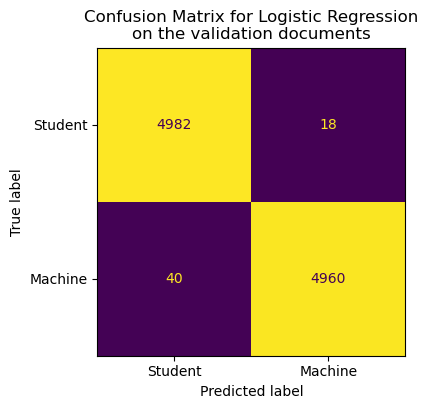

In [517]:
vectorizer = TfidfVectorizer()
X, y = vectorizer.fit_transform(X.text), X.label
logistic = LogisticRegression(max_iter=1000,class_weight={0: 3}).fit(X,y)
y_pred = logistic.predict(vectorizer.transform(validationSet.text))
print( classification_report(validationSet.label,
                             y_pred,
                             zero_division=0))

                             
plt.style.use('default')
fig, ax = plt.subplots(figsize=(4,4))
ConfusionMatrixDisplay.from_predictions(validationSet.label,
                                             y_pred,
                                             colorbar=False,
                                             ax=ax)
ax.xaxis.set_ticklabels(['Student','Machine'])
ax.yaxis.set_ticklabels(['Student','Machine'])
_ = ax.set_title(
    f"Confusion Matrix for Logistic Regression\non the validation documents"
)

## Part B

### 1. Keep a test set apart and split the train data into portions (10%, …, 90%, 100%).

In [128]:
# Load my AI text
myLLM = pd.read_csv('augmentation.csv')
myLLM['generated'] = 1
myLLM.head()

,model,prompt,text,generated
0,0,0,"In recent years, our society has been grapplin...",1
1,0,0,"For most people, hopping in a car is the norm ...",1
2,0,0,"In recent years, the issue of limiting car usa...",1
3,0,0,As high school students navigating our way thr...,1
4,0,0,"Hey, fellow students! Let's dive into a topic ...",1


In [712]:
newTrainDF = pd.concat([trainDF[['text','generated']].sample(80, random_state=42),
                        myLLM[['text', 'generated']]
])

# shuffled = trainSet.sample(frac=1, random_state=42)
newTrainDF = newTrainDF.sample(frac=1, random_state=42)
newTrainDF = newTrainDF.reset_index(drop=True)
newTrainDF.head()

,text,generated
0,"Dear Mr.Mrs. Senator, The Electoral College is...",0
1,"Hey everyone, let's stop relying on cars so m...",1
2,In the world today you will see cars just abou...,0
3,"Dear State Senator, After experiencing the dis...",0
4,I think that we should change to popular vote ...,0


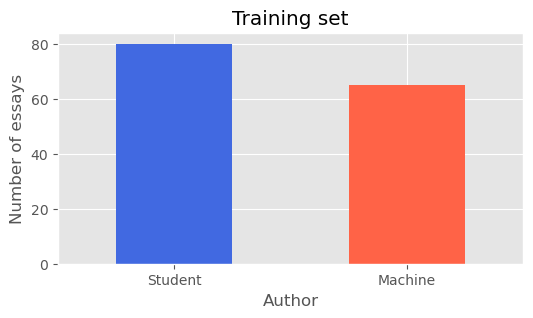

In [713]:
plt.style.use('ggplot')
ax = newTrainDF.generated.value_counts().plot.bar(rot=0, color=['royalblue','tomato'], figsize=(6,3))
ax.set_xticklabels(['Student','Machine'])
ax.set_title('Training set')
ax.set_xlabel('Author')
ax.set_ylabel('Number of essays');

In [714]:
# Split the data into test-train with stratification
train, test = train_test_split(newTrainDF, test_size=0.20, random_state=42, stratify=newTrainDF.generated)

### 2. Train your best performing algorithm on each portion.

In [719]:
vectorizer = TfidfVectorizer()

def benchmark(df, portion, testDF=None):
    if portion:
        # split the train set in train and test
        train, _ = train_test_split(df, test_size=portion, random_state=42, stratify=df.generated)
    else:
        train = df
    # Vectorize x_train, keep y seperate
    X, y = vectorizer.fit_transform(train.text), train.generated
    # FIT model
    logistic = LogisticRegression(max_iter=1000).fit(X,y)
    # Assess on all training data
    y_pred_train = logistic.predict(vectorizer.transform(train.text))
    # Asses on the test data
    y_pred_test = logistic.predict(vectorizer.transform(testDF.text))
    trainF1 = f1_score(train.generated, y_pred_train, zero_division=0, average='macro')
    testF1  = f1_score(testDF.generated, y_pred_test, zero_division=0, average='macro')

    return trainF1, testF1, len(train)

3. Assess each trained instance on the test (the same across portions) and on the training data.

In [720]:
trainF1, testF1, data = [],[], []
for portion in tqdm(np.arange(0.9,-0.1,-0.1), desc='Computing learning curves'):
    x, y, z = benchmark(train, portion.round(2), test)
    trainF1.append(x)
    testF1.append(y)
    data.append(z)


Computing learning curves:   0%|          | 0/10 [00:00<?, ?it/s]

4. Visualize the two curves (train, test), based on an appropriate evaluation measure, diagnosing weak
and strong points of your classifier (a.k.a. the learning curves).
5. Add a regressor to the plot, to estimate how many more texts should you generate to reach the "best"
performance.

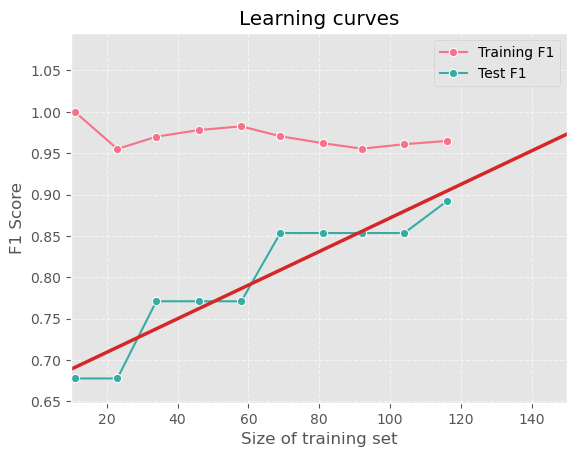

In [748]:
x = data
y = testF1
# Create a color palette
palette = sns.color_palette("husl", 2)

portion = np.arange(10,110,10)
# Plot the lines with labels
fig, ax = plt.subplots()
sns.lineplot(x=x, y=trainF1, label='Training F1', marker='o', color=palette[0])
sns.lineplot(x=x, y=y, label='Test F1', marker='o', color=palette[1])

b, a = np.polyfit(x, y, deg=1)
xseq = np.linspace(0, 200, num=100)
# Plot regression line
ax.plot(xseq, a + b * xseq, color="tab:red", lw=2.5);

# Set labels and title
plt.xlabel('Size of training set')
plt.ylabel('F1 Score')
plt.title('Learning curves')

ax.set_xlim(10,150)
# Add legend
plt.legend()

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.show()

## Part C

### 1. Use K-Means, based on an appropriate text representation and the (estimated) optimum K, to cluster the generated essays, and then the student essays.

In [4]:
trainDF = pd.read_csv('data/data_raw/train_essays.csv')
trainDF.head()

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


In [5]:
# Load my AI text
myLLM = pd.read_csv('augmentation.csv')
myLLM.rename(columns={'prompt':'prompt_id'}, inplace=True)
myLLM['generated'] = 1
myLLM.head()

,model,prompt_id,text,generated
0,0,0,"In recent years, our society has been grapplin...",1
1,0,0,"For most people, hopping in a car is the norm ...",1
2,0,0,"In recent years, the issue of limiting car usa...",1
3,0,0,As high school students navigating our way thr...,1
4,0,0,"Hey, fellow students! Let's dive into a topic ...",1


In [6]:
df = pd.concat([trainDF[['text','generated','prompt_id']].sample(80, random_state=42),
                        myLLM[['text', 'generated','prompt_id']]
])

# shuffled = trainSet.sample(frac=1, random_state=42)
df = df.sample(frac=1, random_state=42)
df = df.reset_index(drop=True)
df.head()

,text,generated,prompt_id
0,Voting. Voting is a pretty big deal that only ...,0,1
1,"Hey everyone, let's stop relying on cars so m...",1,0
2,"Nowadays, there is one sure thing we depend on...",0,0
3,Everyone nowadays is so used to driving a car ...,0,0
4,"AnnoyinglyRepetitive commercials, constant new...",0,1


In [65]:
import nltk
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
plt.style.use('ggplot')

# nltk.download('punkt')
# nltk.download('stopwords')

In [66]:
# Tokenize the text into words
df['words'] = df.text.apply(word_tokenize)
df.head()

,text,generated,prompt_id,words,filtered_words
0,Voting. Voting is a pretty big deal that only ...,0,1,"[Voting, ., Voting, is, a, pretty, big, deal, ...","[voting, voting, pretty, big, deal, comes, aro..."
1,"Hey everyone, let's stop relying on cars so m...",1,0,"[Hey, everyone, ,, let, 's, stop, relying, on,...","[hey, everyone, let, stop, relying, cars, much..."
2,"Nowadays, there is one sure thing we depend on...",0,0,"[Nowadays, ,, there, is, one, sure, thing, we,...","[nowadays, one, sure, thing, depend, go, point..."
3,Everyone nowadays is so used to driving a car ...,0,0,"[Everyone, nowadays, is, so, used, to, driving...","[everyone, nowadays, used, driving, car, even,..."
4,"AnnoyinglyRepetitive commercials, constant new...",0,1,"[AnnoyinglyRepetitive, commercials, ,, constan...","[annoyinglyrepetitive, commercials, constant, ..."


In [67]:
# Remove stop words (common words like 'the', 'and', 'is' that don't carry much meaning)
stop_words = set(stopwords.words('english'))
df['filtered_words'] = df['words'].apply(lambda words: [word.lower() for word in words if word.isalpha() and word.lower() not in stop_words])
df.head()

,text,generated,prompt_id,words,filtered_words
0,Voting. Voting is a pretty big deal that only ...,0,1,"[Voting, ., Voting, is, a, pretty, big, deal, ...","[voting, voting, pretty, big, deal, comes, aro..."
1,"Hey everyone, let's stop relying on cars so m...",1,0,"[Hey, everyone, ,, let, 's, stop, relying, on,...","[hey, everyone, let, stop, relying, cars, much..."
2,"Nowadays, there is one sure thing we depend on...",0,0,"[Nowadays, ,, there, is, one, sure, thing, we,...","[nowadays, one, sure, thing, depend, go, point..."
3,Everyone nowadays is so used to driving a car ...,0,0,"[Everyone, nowadays, is, so, used, to, driving...","[everyone, nowadays, used, driving, car, even,..."
4,"AnnoyinglyRepetitive commercials, constant new...",0,1,"[AnnoyinglyRepetitive, commercials, ,, constan...","[annoyinglyrepetitive, commercials, constant, ..."


In [68]:
student = df[df.generated==0][['filtered_words', 'prompt_id']]
machine = df[df.generated==1][['filtered_words', 'prompt_id']]
print( student.head() )
print( machine.head() )

                                      filtered_words  prompt_id
0  [voting, voting, pretty, big, deal, comes, aro...          1
2  [nowadays, one, sure, thing, depend, go, point...          0
3  [everyone, nowadays, used, driving, car, even,...          0
4  [annoyinglyrepetitive, commercials, constant, ...          1
9  [travel, exploration, new, destinations, thing...          0
                                      filtered_words  prompt_id
1  [hey, everyone, let, stop, relying, cars, much...          0
5  [dear, senator, feel, compelled, express, thou...          1
6  [writing, today, concerned, high, school, stud...          1
7  [dear, senator, name, united, states, renowned...          1
8  [hey, fellow, students, let, dive, topic, buzz...          0


In [69]:
# Train ft_model on student essays
texts_tok = student.filtered_words.values # keep the words for model training
ft_model = FastText(texts_tok, vector_size=300, window=3, min_count=2, workers=10) # train model

In [70]:
def embed(words, model=ft_model):
    # words = word_tokenize(text)
    embeddings = [model.wv[w] for w in words]
    centroid = np.mean(embeddings, axis=0)
    return centroid

# embed("this is an example", model=ft_model)[:50]

  0%|          | 0/9 [00:00<?, ?it/s]

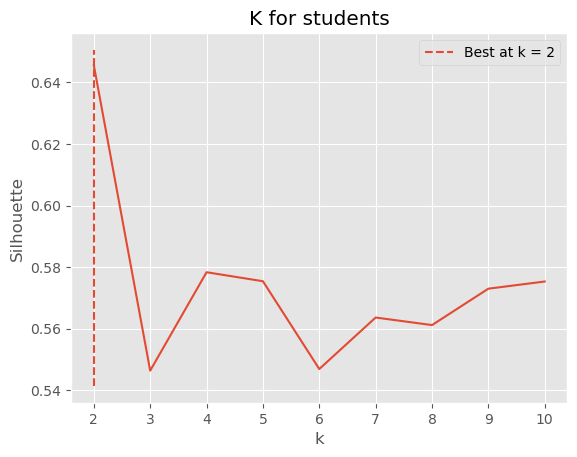

In [99]:
from sklearn.cluster import KMeans
from sklearn import metrics
from tqdm.notebook import tqdm
import os
# Suppress the specific warning
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.cluster._kmeans")
# os.environ["OMP_NUM_THREADS"] = "1"

# Create the embedings for student
X_student = student.filtered_words.apply(lambda x: embed(x, ft_model)).to_list() 

kappas = list(range(2,11))
clustering_models = []
for k in tqdm(kappas):
    km = KMeans(n_clusters=k, 
                   n_init=10, # reboot centre assignment
                   random_state=2023).fit(X_student)
    clustering_models.append(km)

sscores = [metrics.silhouette_score(X_student, km.labels_, sample_size=1000) for km in clustering_models]
best_k_student = kappas[np.argmax(sscores)]
plt.plot(kappas, sscores)
plt.vlines(best_k_student, plt.ylim()[0], plt.ylim()[1], 
           linestyles='dashed', 
           label='Best at k = %d' % best_k_student)
plt.xlabel('k'); 
plt.title('K for students')
plt.ylabel('Silhouette')
plt.legend();
# Save the plot as a PNG file
plt.savefig('best_k_for_students', bbox_inches='tight')

In [72]:
# Train ft_model on machine essays
texts_tok = machine.filtered_words.values # keep the words for model training
ft_model = FastText(texts_tok, vector_size=300, window=3, min_count=2, workers=10) # train model

  0%|          | 0/9 [00:00<?, ?it/s]

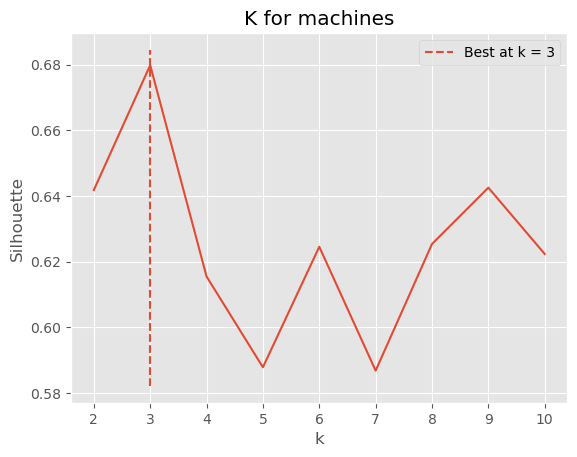

In [73]:
# Create the embedings for machine
X_machine = machine.filtered_words.apply(lambda x: embed(x, ft_model)).to_list() 

kappas = list(range(2,11))
clustering_models = []
for k in tqdm(kappas):
    km = KMeans(n_clusters=k, 
                   n_init=10, # reboot centre assignment
                   random_state=2023).fit(X_machine)
    clustering_models.append(km)

sscores = [metrics.silhouette_score(X_machine, km.labels_, sample_size=1000) for km in clustering_models]
best_k_machine = kappas[np.argmax(sscores)]
plt.plot(kappas, sscores)
plt.vlines(best_k_machine, plt.ylim()[0], plt.ylim()[1], 
           linestyles='dashed', 
           label='Best at k = %d' % best_k_machine)
plt.xlabel('k'); 
plt.title('K for machines')
plt.ylabel('Silhouette')
plt.legend();
# Save the plot as a PNG file
plt.savefig('best_k_for_machine.png', bbox_inches='tight')

The nuber of best K will be different below. Every time fast-text runs it creates different representations. The below numers have been maintained although they are different from the truth for the inshights they have provided.

In [74]:
modelStudent = KMeans(n_clusters=best_k_student, n_init=10, random_state=42).fit(X_student)
modelMachine = KMeans(n_clusters=best_k_machine, n_init=10, random_state=42).fit(X_machine)

In [75]:
student['cluster'] = modelStudent.labels_
machine['cluster'] = modelMachine.labels_

In [206]:
x = student.groupby(['cluster'])['filtered_words'].count().values
y = machine.groupby(['cluster'])['filtered_words'].count().values
matrix = np.zeros((max(len(x),len(y)),2))
matrix[:len(x),0]=x
matrix[:len(y),1]=y
matrix

array([[17., 33.],
       [18., 27.],
       [43.,  5.],
       [ 2.,  0.]])

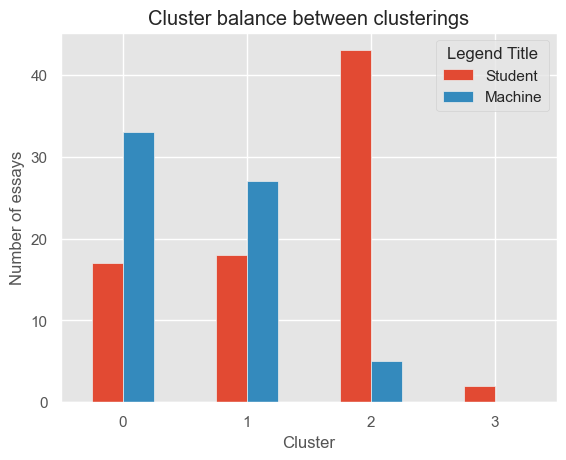

In [208]:
plt.style.use('ggplot')
cc = pd.DataFrame(data= {'Student': matrix[:,0], 'Machine': matrix[:,1]}).reset_index()
ax = cc.plot(x='index', kind='bar', title='Cluster balance between clusterings', rot=0)
# Customize the plot
ax.set_xlabel('Cluster')
ax.set_ylabel('Number of essays')
ax.legend(title='Legend Title')
# Save the plot as a PNG file
plt.savefig('cluster_balance.svg', bbox_inches='tight')
# Show
plt.show()

In [78]:
cc

,index,Student,Machine
0,0,17.0,33.0
1,1,18.0,27.0
2,2,43.0,5.0
3,3,2.0,0.0


In [95]:
cc = student[student.cluster==3]
cc.filtered_words.values

array([list(['travel', 'exploration', 'new', 'destinations', 'things', 'lead', 'mankind', 'creating', 'new', 'ways', 'get', 'wanted', 'made', 'fantastic', 'technologies', 'desire', 'move', 'quickly', 'extensively', 'many', 'could', 'dreamt', 'day', 'mankind', 'could', 'ship', 'large', 'cargo', 'mexico', 'greece', 'fly', 'large', 'planes', 'full', 'people', 'across', 'atlantic', 'even', 'seems', 'common', 'today', 'drive', 'comfort', 'state', 'state', 'short', 'amounts', 'time', 'enjoy', 'ability', 'drive', 'easily', 'place', 'place', 'almost', 'every', 'single', 'american', 'family', 'owns', 'least', 'one', 'car', 'lies', 'problem', 'since', 'big', 'boom', 'industrial', 'car', 'manufacturing', 'early', 'twentieth', 'century', 'america', 'use', 'vehicle', 'spread', 'transportation', 'high', 'class', 'tool', 'public', 'transportation', 'construction', 'delivery', 'overall', 'everyday', 'use', 'relationship', 'man', 'machine', 'part', 'society', 'long', 'practically', 'part', 'lives', 're

### Cluster Names

In [92]:
import itertools
def get_freq_words(df):
    # Flatten the list of lists in the 'filtered_words' column
    all_words = list(itertools.chain.from_iterable(df['filtered_words']))
    # Calculate word frequencies
    freq_dist = FreqDist(all_words)
    # Extract the most frequent words
    most_common_words = freq_dist.most_common(10)  # Change 10 to the desired number of frequent words
    # Print the results
    return [word for word,_ in most_common_words]

In [93]:
# Get frequent words for each cluster of the student group
clusterWords = []
for i in range(best_k_student):
    cc = student[student.cluster==i]
    clusterWords.append(get_freq_words(cc))


- 10 most common words for the 2 clusters of student essays

In [210]:
cdf = pd.DataFrame( clusterWords ).T
cdf.rename(columns={0:'Cluster 1', 1:'Cluster 2', 2:'Cluster 3', 3:'Cluster 4'}, inplace=True)
cdf

,Cluster 1,Cluster 2,Cluster 3,Cluster 4
0,electoral,cars,electoral,cars
1,college,car,college,use
2,vote,people,people,problem
3,people,pollution,vote,source
4,president,would,cars,beeon
5,votes,usage,car,traonsportatioon
6,states,driving,president,eonviroonmeont
7,popular,limiting,states,movemeont
8,election,use,would,primary
9,voting,smog,electors,aon


#### Cluster names for students

Cluster|Title
---|---
1|Electoral College
2|Cars pollute
3|Mixed essays
4|Spelling mistakes

In [211]:
# Get frequent words for each cluster of the student group
clusterWords = []
for i in range(best_k_machine):
    cc = machine[machine.cluster==i]
    clusterWords.append(get_freq_words(cc))


In [212]:
cdf = pd.DataFrame( clusterWords ).T
cdf.rename(columns={0:'Cluster 1', 1:'Cluster 2', 2:'Cluster 3'}, inplace=True)
cdf

,Cluster 1,Cluster 2,Cluster 3
0,car,electoral,like
1,transportation,college,car
2,cars,vote,people
3,usage,system,everyone
4,electoral,popular,vote
5,college,states,get
6,vote,would,better
7,alternative,president,know
8,system,election,let
9,people,people,cars


#### Cluster titles for machine

Cluster|Title
---|---
1|Cars
2|Electoral college
3|Casual writing format

In [217]:
from sklearn.manifold import TSNE
Y = TSNE(n_components=2, init='random').fit_transform(np.array(X_student))

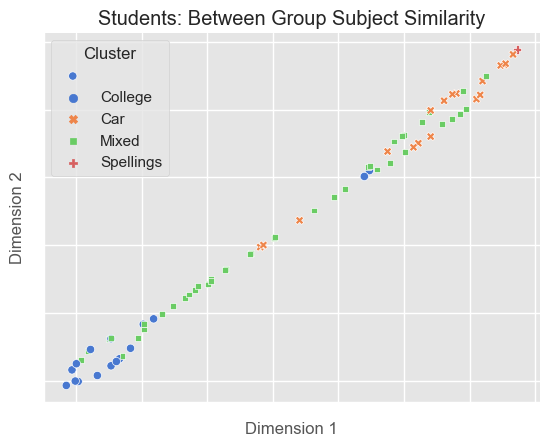

In [218]:
data = pd.DataFrame({'D1':Y[:, 0], # the two dimensions
                     'D2':Y[:, 1],
                     'cluster': student.cluster})
g = sns.scatterplot(data, x='D1', y='D2', hue='cluster', style='cluster', palette='muted');
# Hide x-axis and y-axis labels
g.set(xticklabels=[], yticklabels=[])
# Customize the legend names
plt.legend(title='Cluster', labels=['','College', 'Car', 'Mixed', 'Spellings']);
plt.title('Students: Between Group Subject Similarity');
# Remove spines (axis lines)
sns.despine()
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
# Save
plt.savefig('student_similarities.svg', bbox_inches='tight')
# Show the plot
plt.show()

In [222]:
Y = TSNE(n_components=2, init='random').fit_transform(np.array(X_machine))

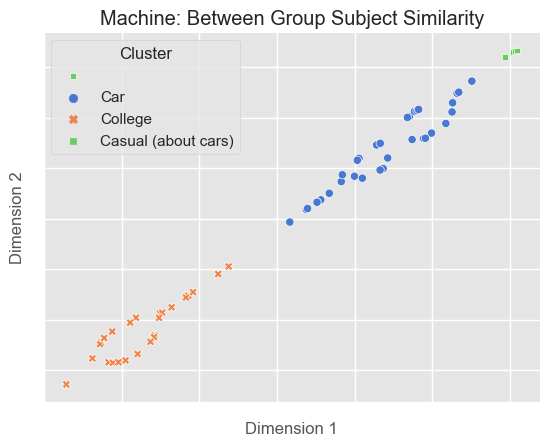

In [223]:
data = pd.DataFrame({'D1':Y[:, 0], # the two dimensions
                     'D2':Y[:, 1],
                     'cluster': machine.cluster})
g = sns.scatterplot(data, x='D1', y='D2', hue='cluster', style='cluster', palette='muted');
# Hide x-axis and y-axis labels
g.set(xticklabels=[], yticklabels=[])
# Customize the legend names
plt.legend(title='Cluster', labels=['','Car', 'College', 'Casual (about cars)']);
plt.title('Machine: Between Group Subject Similarity');
# Remove spines (axis lines)
sns.despine()
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
# Save
plt.savefig('machine_similarities.svg', bbox_inches='tight')
# Show the plot
plt.show()

### 4. Study the similarities between the two clusterings, by finding clusters comprising similar texts.

In [196]:
studentClusterWords = []
for i in range(4):
    studentClusterWords.append(list(itertools.chain.from_iterable(student[student.cluster==i].filtered_words)))

machineClusterWords = []
for i in range(3):
    machineClusterWords.append(list(itertools.chain.from_iterable(machine[machine.cluster==i].filtered_words)))

In [197]:
jaccard = lambda x,y: len(x.intersection(y))/len(x.union(y))
matrix = []
for i, generated in enumerate( machineClusterWords ): 
    similarity = []
    for original in studentClusterWords:
        similarity.append(jaccard(set( generated ),set( original )) )
    matrix.append(similarity)

    # similarities[i,1] = np.mean(similarity)
    # similarities[i,2] = np.max(similarity)

In [198]:
np.array(matrix).T

array([[0.22535211, 0.22175732, 0.17991632],
       [0.27525884, 0.16681299, 0.14609287],
       [0.28558504, 0.1905439 , 0.12515541],
       [0.08027842, 0.0761035 , 0.11747851]])

In [204]:
import numpy as np
import plotly.graph_objects as go

# Given array
data_array = np.array(matrix)

# Categories for the radar chart
categories = ['College', 'Car', 'Mixed', 'Spellings']
machineC = ['Car', 'College', 'Casual']

# Create a radar chart for each row in the array
fig = go.Figure()

for i, row in enumerate( data_array ):
    fig.add_trace(go.Scatterpolar(
        r=np.append(row, row[0]),  # Close the radar chart
        theta=categories + [categories[0]],
        fill='toself',
        # name='data'
        name=machineC[i]
    ))

# Layout customization
fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, np.max(data_array)]
        )
    ),
    showlegend=True,
    title='Similarities Between Clusterings'
)
fig.write_html('radar.html')
# Show the plot
fig.show()


The culmination of the analysis would entail:
1. The removal of the texts that have been removed in step A5.
2. The removal of the texts clustered in 'Spelling' and cluster 'Casual'
3. Re-fit the best classifier and assess. 